# ASX rate tracker

Note: Data prior to 12 April sourced from Matt Cowgill's github repo:
https://github.com/MattCowgill/cash-rate-scraper.git

## Python set-up

In [1]:
import glob
from pathlib import Path
from functools import cache

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

import plotting as pg
import rba_data_capture as rdc

In [3]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/ASX/"
pg.set_chart_dir(CHART_DIR)
pg.clear_chart_dir(CHART_DIR)

RFOOTER = 'Source: ASX'
LFOOTER = 'Australia. '
FOOTERS = {'lfooter': LFOOTER, 'rfooter': RFOOTER}

# True to see the charts in the notebook
SHOW=True

In [4]:
# Save the combined data to a file (for posterity?)
SAVE_DIR = "./ASX-COMBINED/"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
SAVE_FILE = SAVE_DIR + "ASX-COMBINED.csv"

## ASX data cleaning and aggregation

In [5]:
def aggregate_data() -> pd.DataFrame:
    """Aggregate daily cash rate data into a single dataframe.
    Delete daily data that looks odd."""

    # Find files 
    directory = "./ASX_DAILY_DATA/"
    file_stem = 'scraped_cash_rate_'
    pattern = f"{directory}{file_stem}*.csv"
    files = glob.glob(pattern)

    # Read each file into a dataframe and then put it in a dictionary
    dict_of_series = {}
    for file in files:
        day_data = pd.read_csv(file, index_col=0) 
        scraped_date = day_data['scrape_date'].iloc[0]
        cash_rate_day = day_data['cash_rate'].round(3)
        if cash_rate_day.isnull().any():
            # drop the date if there are any missing values
            continue
        cash_rate_day.index = pd.PeriodIndex(cash_rate_day.index, freq='M')
        dict_of_series[scraped_date] = cash_rate_day

    # Create a new dataframe, order rhw rows and columns
    combined_df = (
        pd.DataFrame(dict_of_series)
        .T
        .sort_index(ascending=True)
        .sort_index(ascending=True, axis=1)
    )
    combined_df.index = pd.PeriodIndex(combined_df.index, freq='D')

    # This list comes from Matt Cowgill's code
    matts_drop_list = [
        "2022-08-06", "2022-08-07", "2022-08-08", "2023-01-18",
        "2023-01-24", "2023-01-31", "2023-02-02", "2022-12-30",
        "2022-12-29"
    ]
    combined_df = combined_df.drop(matts_drop_list, errors='ignore')

    # drop saturday/sunday data
    combined_df = combined_df[~combined_df.index.dayofweek.isin([5, 6])]

    # save to file
    combined_df.to_csv(SAVE_FILE)

    return combined_df


df = aggregate_data()

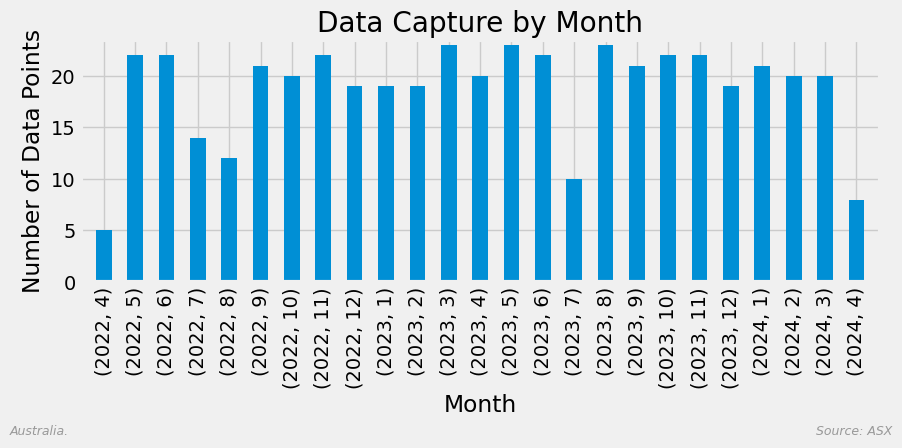

In [6]:
def data_capture_by_month():
    """Bar chart - number of data points captured by year-month.
    This is a good way to see where there are gaps in the data."""

    ax = df.groupby([df.index.year, df.index.month]).agg({'count'}).max(axis=1).plot.bar()
    pg.finalise_plot(
        ax, 
        title='Data Capture by Month', 
        xlabel='Month',
        ylabel='Number of Data Points',
        **FOOTERS,
        show=SHOW,
    )


data_capture_by_month()

## Anticipated RBA Official Cash Rates

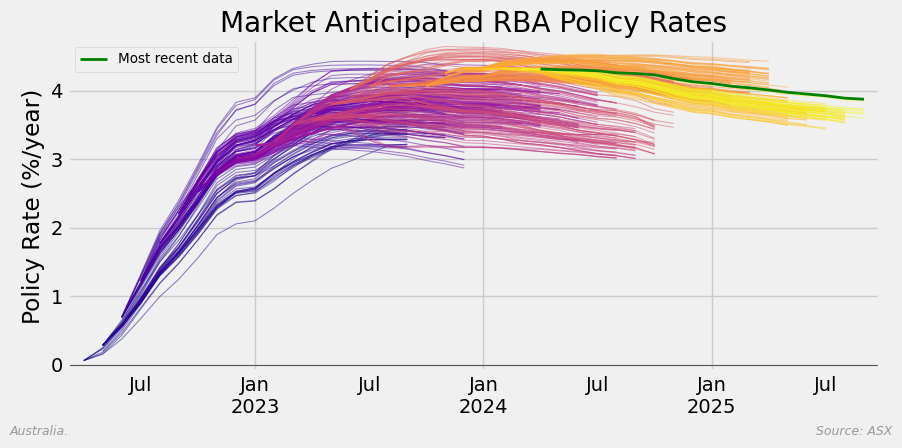

In [7]:
def plot_anticipated():
    """Plot daily ASX rate tracker implied market forecasts."""

    data = df.T.copy()
    columns = [f"_{x}" for x in data.columns]
    data.columns = columns
    num_columns = len(data.columns)
    colors = sns.color_palette("plasma", num_columns)
    ax = data.plot(color=colors, lw=0.75, alpha=0.5)
    columns[-1] = columns[-1].replace('_', '')
    data.columns = columns
    ax = data[data.columns[-1]].plot(color='green', lw=2, label='Most recent data')

    pg.finalise_plot(
        ax, 
        title='Market Anticipated RBA Policy Rates', 
        ylabel='Policy Rate (%/year)',
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={'loc': 'best', 'fontsize': 'x-small'},
        show=SHOW,
    )


plot_anticipated()

## Monthly against RBA rate


In [8]:
@cache
def periodic_rba(freq='M') -> pd.Series:
    """Get the RBA cash rate data from the RBA website.
    Get with either a monthly or daily frequency PeriodIndex."""

    # get the data
    _a2_meta, a2_data = rdc.get_data("Monetary Policy Changes – A2")
    a2_data = a2_data['ARBAMPCNCRT']
    a2_data.index = pd.PeriodIndex(a2_data.index, freq=freq)
    drops = a2_data.index.duplicated(keep='last')
    a2_data = a2_data[~drops]

    # add today's data if it is missing (usually is)
    today = pd.Period(pd.Timestamp("today"), freq=freq)
    if today > a2_data.index[-1]:
        last = a2_data.iloc[-1]
        a2_data[today] = last
        a2_data = a2_data.sort_index()

    # restore missing periods
    new_index = pd.period_range(start=a2_data.index.min(), end=a2_data.index.max())
    a2_data = a2_data.reindex(new_index, fill_value=np.nan).ffill()

    # drop data prior to the commencing point
    commencing = "2022-04-01"
    a2_data = a2_data[a2_data.index >= commencing]

    return a2_data

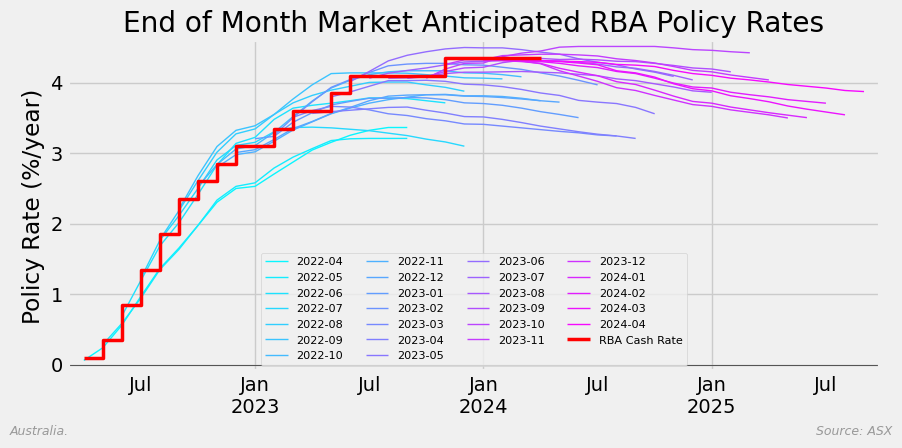

In [9]:
def plot_against_rba():
    """Plot end of month ASX rate tracker forecasts against RBA cash rate.
    Limit to end of month to declutter the plot."""

    # Get end-of-month ASX forecast data
    asx_data = df.copy()
    asx_data.index = pd.PeriodIndex(asx_data.index, freq='M')
    drops = asx_data.index.duplicated(keep='last')
    asx_data = asx_data[~drops].T

    # plot the ASX data with a different colour for each column
    num_columns = len(asx_data.columns)
    colors = sns.color_palette("cool", num_columns)
    ax = asx_data.plot(color=colors, lw=1)

    # Get and plot the RBA data
    a2_data = periodic_rba(freq='M')
    ax = a2_data.plot(
        ax=ax,
        color="red", 
        lw=2.5, 
        label="RBA Cash Rate",
        drawstyle='steps-post',
    )

    # finalise the plot
    pg.finalise_plot(
        ax, 
        title='End of Month Market Anticipated RBA Policy Rates', 
        ylabel='Policy Rate (%/year)',
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={'loc': 'lower center', 'fontsize': 'xx-small', 'ncols': 4},
        show=SHOW,
    )


plot_against_rba()

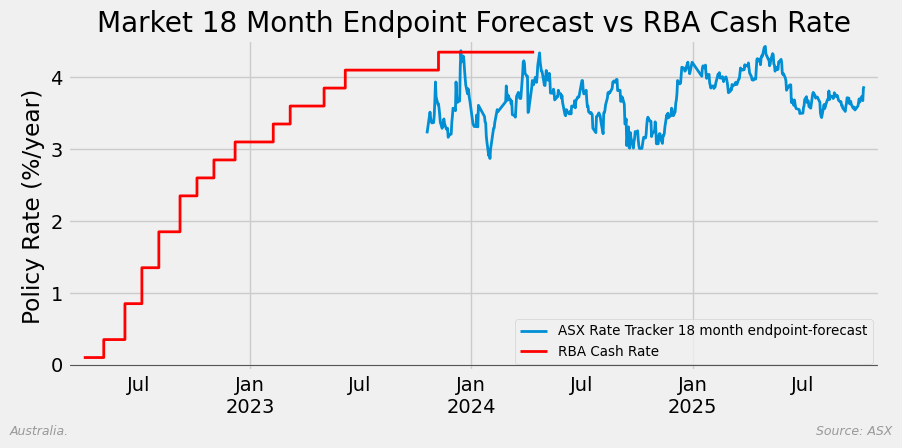

In [10]:
def endpoint_comparison():
    """Compare the endpoint forecast against the actual RBA rate."""

    # Endpoint rate against the actual RBA rate
    endpoint = df.copy().T.ffill().iloc[-1]
    endpoint.index += int(365 * 3 / 2)  # 18 months in days
    rba = periodic_rba(freq='D')
    ax = endpoint.plot(label='ASX Rate Tracker 18 month endpoint-forecast', lw=2)
    rba.plot(ax=ax, label='RBA Cash Rate', lw=2, color='red', drawstyle='steps-post')
    pg.finalise_plot(
        ax, 
        title='Market 18 Month Endpoint Forecast vs RBA Cash Rate', 
        ylabel='Policy Rate (%/year)',
        y0=True,
        zero_y=True,
        **FOOTERS,
        legend={'loc': 'best', 'fontsize': 'x-small'},
        show=SHOW,
    )


endpoint_comparison()

## 25 basis point movements

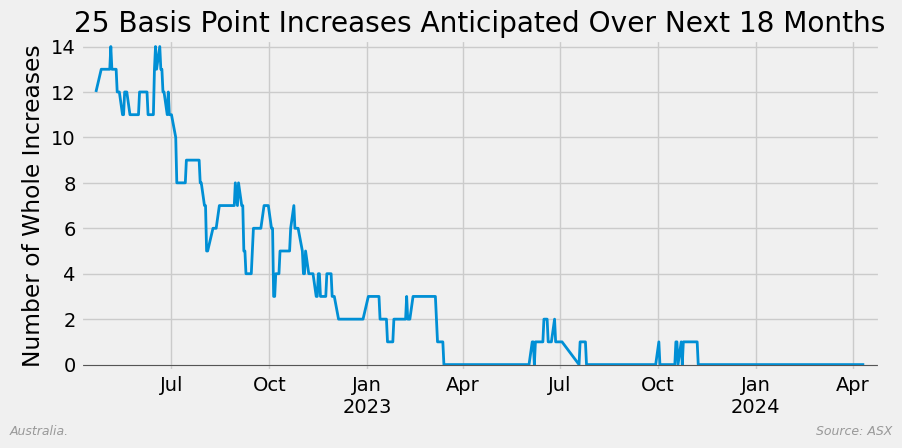

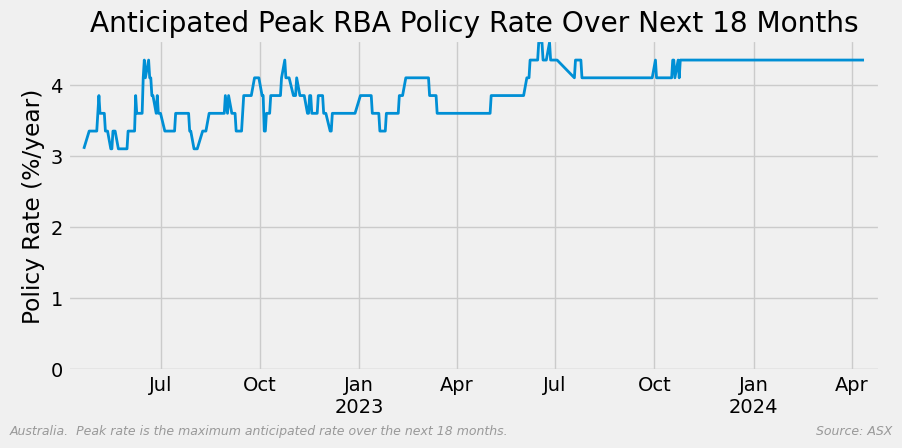

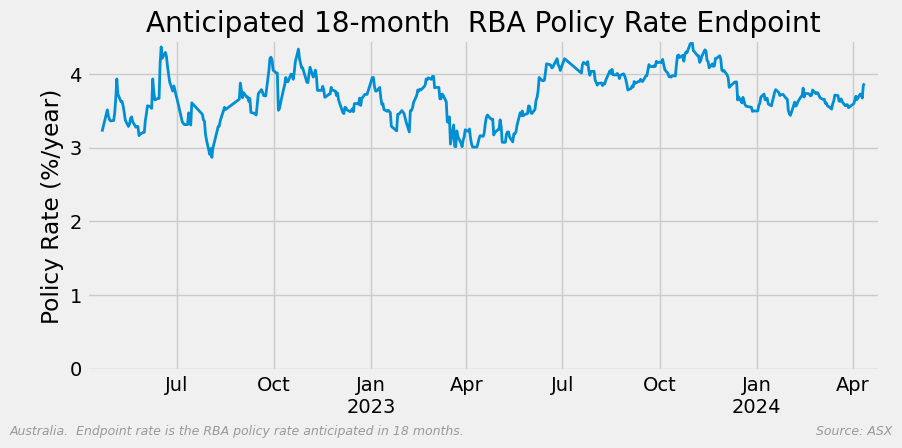

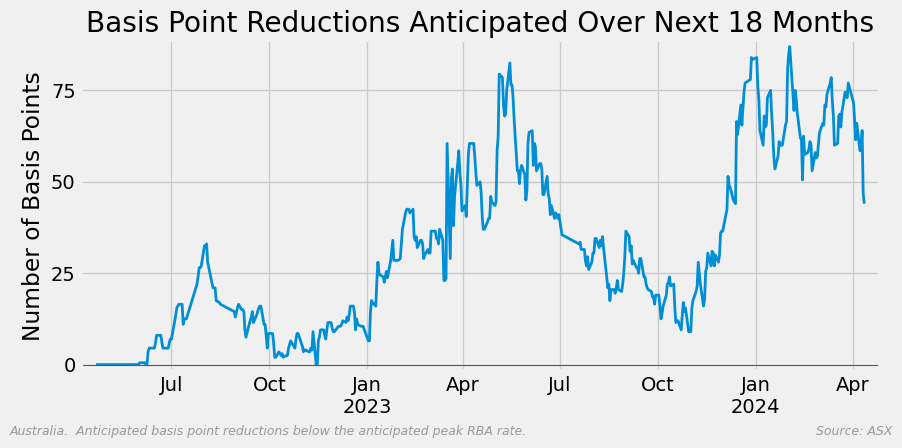

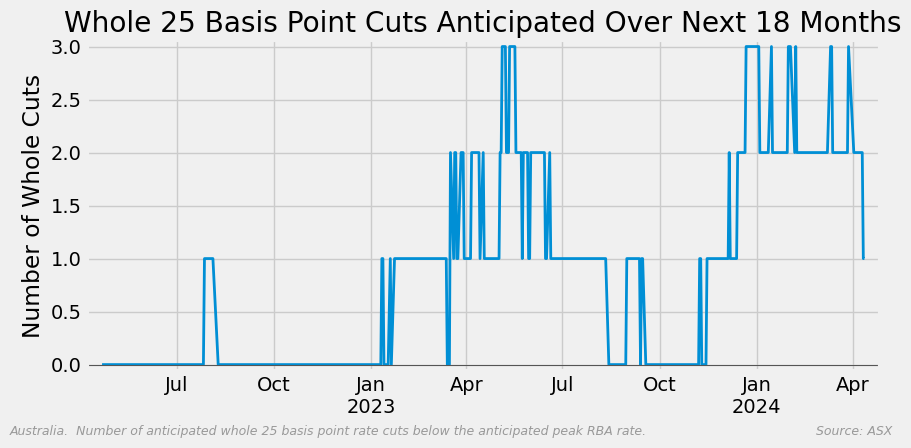

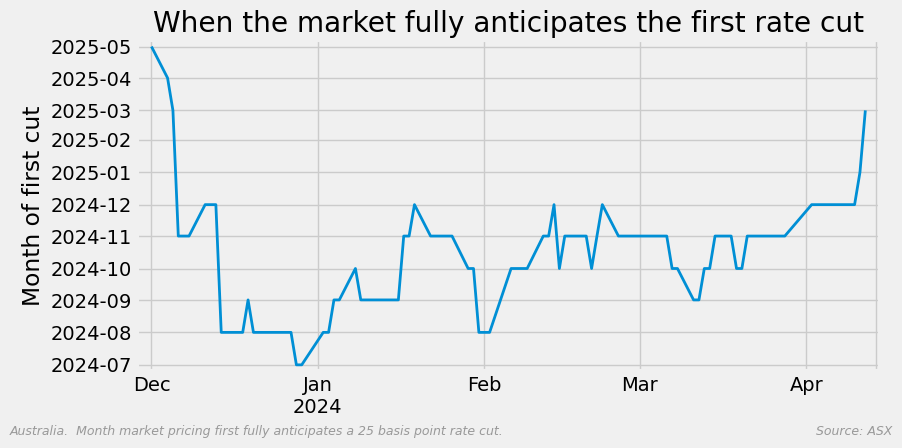

In [11]:
LW = 2
def plot_movements():
    """Plots in respect of 25 basis point movements in the ASX data."""

    # get the data
    rba = periodic_rba(freq='D')
    peak = df.copy().T.max()
    climb = (peak - rba) / 0.25
    climb = climb.dropna().astype(int).where(climb > 0, 0)

    # plot the number of anticipated increases
    ax = climb.plot(lw=LW)
    pg.finalise_plot(
        ax, 
        title='25 Basis Point Increases Anticipated Over Next 18 Months', 
        ylabel='Number of Whole Increases',
        y0=True,
        zero_y=True,
        **FOOTERS,
        show=SHOW,
    )

    # capped_peak = the most likely peak rate
    # assumes all movements are limited to 25 basis points
    capped_peak = (rba + climb * 0.25).dropna()
    capped_peak = (
        capped_peak.where(capped_peak > rba[capped_peak.index], rba[capped_peak.index])
    )
    ax = capped_peak.plot(lw=LW)
    pg.finalise_plot(
        ax, 
        title='Anticipated Peak RBA Policy Rate Over Next 18 Months', 
        ylabel='Policy Rate (%/year)',
        y0=True,
        zero_y=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Peak rate is the maximum anticipated rate over the next 18 months.",
        show=SHOW,
    )

    # Anticipated 18-month endpoint rate
    endpoint = df.copy().T.ffill().iloc[-1]
    ax = endpoint.plot(lw=LW)
    pg.finalise_plot(
        ax, 
        title='Anticipated 18-month  RBA Policy Rate Endpoint', 
        ylabel='Policy Rate (%/year)',
        y0=True,
        zero_y=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Endpoint rate is the RBA policy rate anticipated in 18 months.",
        show=SHOW,
    )

    # Anticipated basis point cuts, after anticipated peak
    cuts = (peak - endpoint) * 100
    cuts = cuts.dropna().where(cuts > 0, 0)
    ax = cuts.plot(lw=LW)
    top = ((cuts / 25).astype(int).max() + 1) * 25
    yticks = tuple(range(0, top, 25))
    ax.set_yticks(yticks)
    pg.finalise_plot(
        ax, 
        title='Basis Point Reductions Anticipated Over Next 18 Months', 
        ylabel='Number of Basis Points',
        y0=True,
        zero_y=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Anticipated basis point reductions below the anticipated peak RBA rate. ",
        show=SHOW,
    )

    # Anticipated whole 25 basis point cuts
    whole_cuts = (cuts / 25).astype(int)
    ax = whole_cuts.plot(lw=LW)
    pg.finalise_plot(
        ax, 
        title='Whole 25 Basis Point Cuts Anticipated Over Next 18 Months', 
        ylabel='Number of Whole Cuts',
        y0=True,
        zero_y=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Number of anticipated whole 25 basis point rate cuts below the anticipated peak RBA rate. ",
        show=SHOW,
    )

    # timing of first cut
    # Note - really it is only since December 2023 that markets have
    # started to consistently anticipate cuts over the forward 18 months
    start = "2023-12-01"
    peak2 = capped_peak[capped_peak.index >= start]
    forecasts = df.copy().T
    forecasts = forecasts[forecasts.columns[forecasts.columns >= start]]
    forecasts = forecasts[forecasts.index >= start]
    forecasts = forecasts.sub(peak2, axis=1)
    forecasts = forecasts.where(forecasts <= -0.25, np.nan)
    first = pd.Series([forecasts[col].first_valid_index().to_timestamp(how='end') for col in forecasts.columns])
    first.index = forecasts.columns
    ax = first.plot(lw=LW)
    pg.finalise_plot(
        ax, 
        title='When the market fully anticipates the first rate cut', 
        ylabel='Month of first cut',
        y0=True,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} Month market pricing first fully anticipates a 25 basis point rate cut. ",
        show=SHOW,
    )


plot_movements()

## Finished

In [12]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Apr 14 2024 10:08:51

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
matplotlib: 3.8.4

Watermark: 2.4.3

